In [1]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!pip install -q pyspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["PATH"] += ":/usr/lib/jvm/java-11-openjdk-amd64/bin"

In [3]:
import pyspark
sc = pyspark.SparkContext(appName="FraudDetection")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/17 18:42:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
from pyspark import SparkConf
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("FraudDetection") \
    .getOrCreate()

spark.sparkContext.getConf().getAll()
spark

In [86]:
import numpy as np 
import pandas as pd 
import json
import matplotlib.pyplot as plt
import warnings
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler,StandardScaler
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import avg, stddev, count, hour, col, max
from pyspark.ml import Pipeline
from sklearn.manifold import TSNE
import seaborn as sns


warnings.filterwarnings("ignore")
data_path='/kaggle/input/transactions-data-big-data/Transactions Data'

In [50]:
from pyspark.sql import functions as F

# Load the users data
users_df = spark.read.csv(f"{data_path}/users.csv", header=True, inferSchema=True)

# Remove '$' and ',' and cast the columns to double type
users_df = users_df.withColumn("per_capita_income", F.regexp_replace("per_capita_income", "[\$,]", "").cast("double"))
users_df = users_df.withColumn("yearly_income", F.regexp_replace("yearly_income", "[\$,]", "").cast("double"))
users_df = users_df.withColumn("total_debt", F.regexp_replace("total_debt", "[\$,]", "").cast("double"))

print(users_df.count())
# Check the count of rows
users_df.show(3)

1219
+---------+-----------+--------------+----------+-----------+------+-------------------+--------+---------+-----------------+-------------+----------+------------+----------------+
|client_id|current_age|retirement_age|birth_year|birth_month|gender|            address|latitude|longitude|per_capita_income|yearly_income|total_debt|credit_score|num_credit_cards|
+---------+-----------+--------------+----------+-----------+------+-------------------+--------+---------+-----------------+-------------+----------+------------+----------------+
|     1645|         62|            65|      1957|         11|Female|    58 Federal Lane|   41.47|   -81.85|          29692.0|      60541.0|  160456.0|         716|               3|
|     1591|         58|            66|      1961|          6|Female|   2200 Third Drive|   48.28|  -122.62|          16537.0|      33717.0|   58236.0|         698|               6|
|     1959|         46|            59|      1973|          4|  Male|8750 Lake Boulevard|  

In [51]:
from pyspark.sql import functions as F

# Read the transactions data
transactions_df = spark.read.csv(f"{data_path}/transactions.csv", header=True, inferSchema=True)

# Remove '$' and ',' and cast the 'amount' column to double type
transactions_df = transactions_df.withColumn("amount", F.regexp_replace("amount", "[\$,]", "").cast("double"))

# Check the count of rows
print(transactions_df.count())
transactions_df.show(3)

8914963
+-------+-------------------+---------+-------+------+-----------------+-----------+---------------+----+--------+------+
|     id|               date|client_id|card_id|amount|         use_chip|merchant_id|  merchant_city| mcc|  errors|target|
+-------+-------------------+---------+-------+------+-----------------+-----------+---------------+----+--------+------+
|7475341|2010-01-01 00:27:00|     1797|   1127| 43.33|Swipe Transaction|      33326|        Kahului|4121|No Error|    No|
|7475347|2010-01-01 00:36:00|      114|   3398| -64.0|Swipe Transaction|      61195|North Hollywood|5541|No Error|    No|
|7475378|2010-01-01 01:19:00|     1575|   2112| 17.14|Swipe Transaction|      29232|         Osprey|4121|No Error|    No|
+-------+-------------------+---------+-------+------+-----------------+-----------+---------------+----+--------+------+
only showing top 3 rows



In [52]:
# Read the cards data
cards_df = spark.read.csv(f"{data_path}/cards.csv", header=True, inferSchema=True)

# Remove '$' and ',' and cast the 'credit_limit' column to double type
cards_df = cards_df.withColumn("credit_limit", F.regexp_replace("credit_limit", "[\$,]", "").cast("double"))

# Check the count of rows
cards_df.count()

4514

In [53]:
# Calculate spending per user
user_spending = transactions_df.groupBy("client_id").agg(
    F.count("*").alias("num_transactions"),
    F.avg("amount").alias("avg_transaction_amount"),
    F.sum("amount").alias("total_spent"),
    F.stddev("amount").alias("std_transaction_amount")
)
user_spending.show(3)

+---------+----------------+----------------------+------------------+----------------------+
|client_id|num_transactions|avg_transaction_amount|       total_spent|std_transaction_amount|
+---------+----------------+----------------------+------------------+----------------------+
|     1959|            3451|      86.3550449145175| 298011.2599999999|     163.6705151652383|
|      148|            7426|    35.218777269054684| 261534.6400000001|    57.421591677235426|
|     1591|           14659|     28.58476908383927|419024.12999999983|     58.41412838493421|
+---------+----------------+----------------------+------------------+----------------------+
only showing top 3 rows



In [63]:
# Merge user and card features
cards_summary = cards_df.groupBy("client_id").agg(
    F.count("*").alias("num_cards"),
    F.avg("credit_limit").alias("avg_credit_limit"),
    F.sum("credit_limit").alias("total_credit_limit"),
)
cards_summary.show(3)

+---------+---------+------------------+------------------+
|client_id|num_cards|  avg_credit_limit|total_credit_limit|
+---------+---------+------------------+------------------+
|     1645|        3|17949.666666666668|           53849.0|
|     1591|        6|           10753.5|           64521.0|
|     1959|        1|           11100.0|           11100.0|
+---------+---------+------------------+------------------+
only showing top 3 rows



In [77]:
# Merge all features
features_df = users_df.join(user_spending, on="client_id", how="inner") \
                      .join(cards_summary, on="client_id", how="inner")

# Drop unused or high-cardinality columns
drop_cols = ["address", "birth_month", "birth_year","client_id","latitude","longitude","gender","any_card_on_dark_web","retirement_age","current_age"]
features_df = features_df.drop(*drop_cols)

features_df.show(1)

+-----------------+-------------+----------+------------+----------------+----------------+----------------------+-----------------+----------------------+---------+----------------+------------------+
|per_capita_income|yearly_income|total_debt|credit_score|num_credit_cards|num_transactions|avg_transaction_amount|      total_spent|std_transaction_amount|num_cards|avg_credit_limit|total_credit_limit|
+-----------------+-------------+----------+------------+----------------+----------------+----------------------+-----------------+----------------------+---------+----------------+------------------+
|          25565.0|      52130.0|   80367.0|         701|               1|            3451|      86.3550449145175|298011.2599999999|     163.6705151652383|        1|         11100.0|           11100.0|
+-----------------+-------------+----------+------------+----------------+----------------+----------------------+-----------------+----------------------+---------+----------------+----------

In [78]:
input_cols = [
    "per_capita_income", "yearly_income", "total_debt",
    "credit_score", "num_credit_cards", "num_transactions", "avg_transaction_amount",
    "total_spent", "std_transaction_amount", "num_cards", "avg_credit_limit",
    "total_credit_limit", 
]
# Assemble and scale features first
assembler = VectorAssembler(inputCols=input_cols, outputCol="unscaled_features")
scaler = StandardScaler(inputCol="unscaled_features", outputCol="features")

assembled_scaled = Pipeline(stages=[assembler, scaler]).fit(features_df).transform(features_df)

# Elbow method
cost = []
for k in range(2, 10):
    kmeans = KMeans(k=k, seed=42, featuresCol="features", predictionCol="cluster")
    model = kmeans.fit(assembled_scaled)
    cost.append(model.summary.trainingCost)

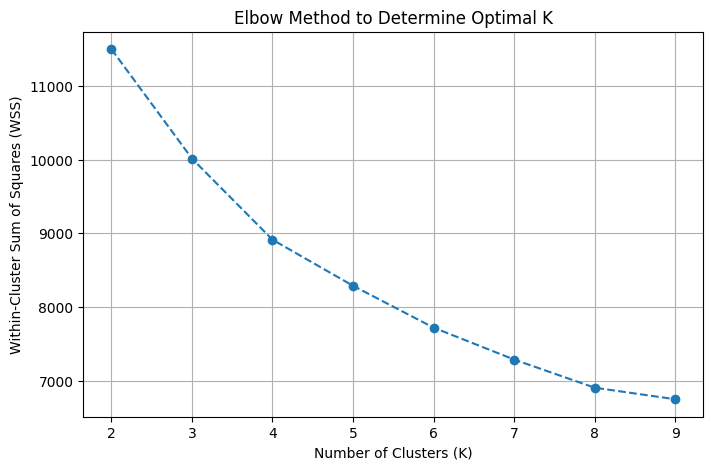

In [80]:
plt.figure(figsize=(8, 5))
plt.plot(range(2, 10), cost, marker='o', linestyle='--')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Within-Cluster Sum of Squares (WSS)")
plt.title("Elbow Method to Determine Optimal K")
plt.xticks(range(2, 10))  # Force x-axis to show integer values
plt.grid(True)
plt.show()

In [88]:
# optimal number found from the elbow graph
best_k = 4


kmeans = KMeans(k=best_k, seed=42, featuresCol="features", predictionCol="cluster")
model = kmeans.fit(assembled_scaled)
clustered_df = model.transform(assembled_scaled)

clustered_df.groupBy("cluster").agg(
    F.count("*").alias("num_users"),
    F.avg("yearly_income").alias("avg_income"),
    F.avg("total_spent").alias("avg_spending"),
    F.avg("credit_score").alias("avg_credit_score")
).orderBy("cluster").show()

+-------+---------+------------------+------------------+-----------------+
|cluster|num_users|        avg_income|      avg_spending| avg_credit_score|
+-------+---------+------------------+------------------+-----------------+
|      0|      288| 60673.86111111111| 442473.3049652781|702.0277777777778|
|      1|      344|  38812.0523255814|340561.83843023254|736.0813953488372|
|      2|       42|121748.40476190476| 605264.8411904761|709.6904761904761|
|      3|      545| 34972.34495412844|207129.33937614688|704.9724770642201|
+-------+---------+------------------+------------------+-----------------+



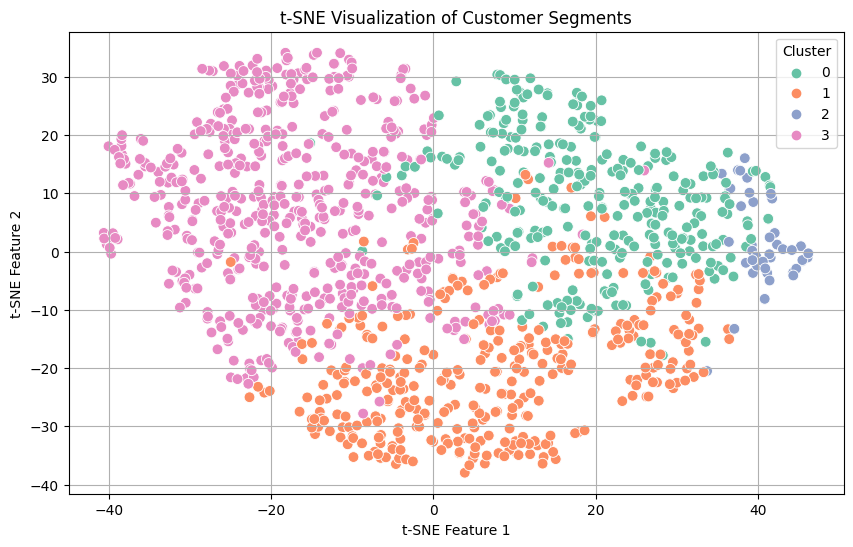

In [89]:
clustered_pandas = clustered_df.select("features", "cluster").toPandas()


X = np.array([np.array(vec.toArray()) for vec in clustered_pandas["features"]])
y = clustered_pandas["cluster"]

# Reduce to 2 dimensions
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X)


# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='Set2', s=60)
plt.title("t-SNE Visualization of Customer Segments")
plt.xlabel("t-SNE Feature 1")
plt.ylabel("t-SNE Feature 2")
plt.legend(title='Cluster')
plt.grid(True)
plt.show()